# 0.0. IMPORTS

In [1]:
import math
import numpy  as np
import pandas as pd
import inflection

import seaborn as sns

from matplotlib import pyplot as plt
from IPython.core.display import HTML

## 0.1. Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading data

In [4]:
df_sales_raw = pd.read_csv( '../data/train.csv', low_memory=False ) #RAW sales without cleaning
df_store_raw = pd.read_csv( '../data/store.csv', low_memory=False ) #RAW Store without cleaning
#Low-memory True -Read by chunks )

# merge
df_raw = pd.merge( df_sales_raw, df_store_raw, how='left', on='Store' ) #Merge between the 2 datasets 
#Store column reference for merge

# 1.0 DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy() #Copy of the dataset - because if something goes wrong its just run df_raw again. 
#Best procedure for development

## 1.1. Rename Columns

In [23]:
# The purpose is easy acess to the columns - CamelCase Format - (Kaggle is a controled enviroment)
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )
#Inflection is a string transformation library. It singularizes and pluralizes English words, and transforms strings from CamelCase to underscored string. 

cols_new = list( map( snakecase, cols_old ) )# Mapping in all the columns on the list cols_old

# rename for have snake_cases
df1.columns = cols_new

## 1.2. Data Dimensions

In [24]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) ) #Shape print the number of Rows and Columns 
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [25]:
df1['date'] = pd.to_datetime( df1['date'] ) #Object -> Datetime
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [26]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [27]:
df1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
643212,643,1,2013-12-02,14000,1506,1,1,0,0,a,a,230.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"


In [28]:
#1) COMPETITION DISTANCE  """(distance in meters) to the nearest competitor """""   
#df1['competition_distance'].max()
#output 75.860m - Colocar um valor mais alto quando tiver um valor faltante para atribuir que não há competição!
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 200000.0 if math.isnan( x ) else x ) 
# 1) Uma distancia muito maior é a mesma coisa que dizer que nao tem um competidor proximo

#2) COMPETITION OPEN SINCE[MONTH] - Gives the approximate year and month of the time the nearest competitor was opened
# Temos competidores proximos mas não sabemos quando abriu (Alguem esqueceu de anotar quando abriu?, ou abriu antes da loja rossman)
# Assumption : Para etapa de FEATURE ENGENEERING (será preciso variaveis de tempo [Quanto tempo faz desde que determinado evento ocorreu])
# Uma loja sem competidores proximos tem uma certa quantidade de venda, que cai quando o publico é compartilhado com outras lojas
# Apos o regime permanente das duas lojas pode haver uma estabilização, porem durante DETERMINADO TEMPO faça sentido a oscilação.
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan( x['competition_open_since_month'] ) else x['competition_open_since_month'], axis=1 )

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['competition_open_since_year'] ) else x['competition_open_since_year'], axis=1 )
#Substituir com o VIM (Plugin pro Jupyter )
#promo2_since_week           
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan( x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

#promo2_since_year           
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan( x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

#PROMO INTERVAL (meses que a promoção 2 ficou ativa)
# Proposta é splitar da coluna e criar uma lista / IF a data estiver dentro da lista cria uma coluna pra dizer que a promoção esta ativa
# VI - Registro + Recording = Screencasting
month_map = {1: 'Jan',  2: 'Fev',  3: 'Mar',  4: 'Apr',  5: 'May',  6: 'Jun',  7: 'Jul',  8: 'Aug',  9: 'Sep',  10: 'Oct', 11: 'Nov', 12: 'Dec'}
# os nomes do intervaloes estao em ingles
df1['promo_interval'].fillna(0, inplace=True )
#Extraindo o mes da data e aplicando o dicionario para fazer a tradução.
df1['month_map'] = df1['date'].dt.month.map( month_map ) #Posso saber se esta na promoção ou não 
#COndições 1) Ver se o month map esta dentro da lista 2) Se não (else) : 0 , tem que olhar pra o promo interval e saber que : Se a promo interval for = 0, voltar a 0 se não vai fazer a proxima condição e voltar igual a 1
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split( ',' ) else 0, axis=1 )


In [29]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Data Types

In [30]:
# competiton
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype( int )
    
# promo2
df1['promo2_since_week'] = df1['promo2_since_week'].astype( int )
df1['promo2_since_year'] = df1['promo2_since_year'].astype( int )

## 1.7. Descriptive Statistics

In [31]:
# Detectar Anomalias e entender o negocio
# Metricas - Dispersao () e Tendencia Central (Media, mediana)
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

### 1.7.1. Numerical Atributes

In [32]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T #Std
d2 = pd.DataFrame( num_attributes.apply( min ) ).T #min 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T #max
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T #range
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T #Skew
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T #kurtosis

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index() #Metrics
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.155231,0.0,0.362124,1.904152,1.625796


##### Observações : Variaveis sem erro de sistema (0 Vendas quando a loja estava fechada e 41.551 quando aberta)
##### Vendas - Mean - Median São parecidas e por isso conclui-se que não há um deslocamento tão grande da normal
##### Skew - Proxima de 0 confirmando o que ja havia sido assumido
##### Kurtosis - Proxima de 1 Pico muito grande

<AxesSubplot:xlabel='competition_distance'>

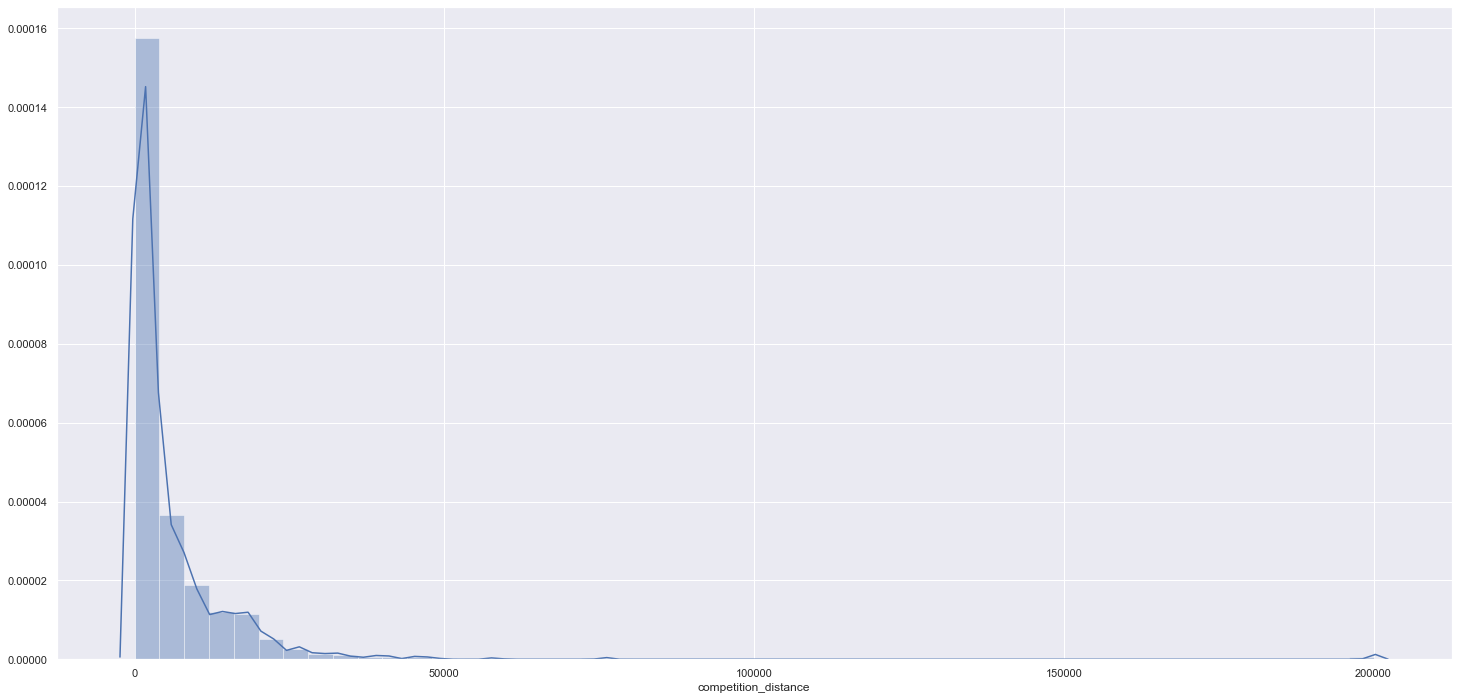

In [37]:
sns.distplot( df1['competition_distance'] ) # Skew Muito alta # Distribuissão de Poisson? #Concentração muito alta de valores no inicio 
#Concentração a esquerda

<AxesSubplot:xlabel='sales'>

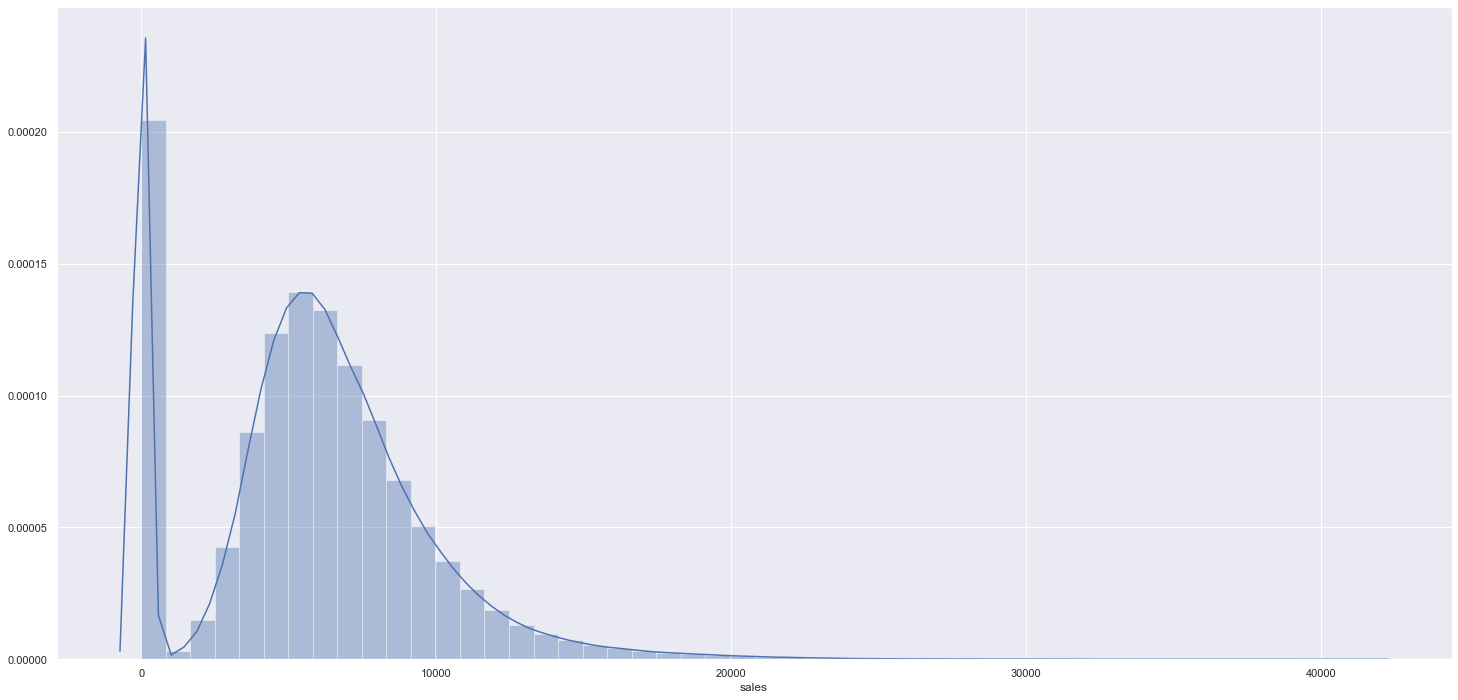

In [34]:
sns.distplot( df1['sales'] ) #0 Deslocado da normal  pois tem um skew positiva

### 1.7.2. Categorical Atributes

In [38]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday                    4
store_type                       4
assortment                       3
competition_open_since_month    12
competition_open_since_year     23
promo2_since_week               52
promo2_since_year                7
promo_interval                   4
month_map                       12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

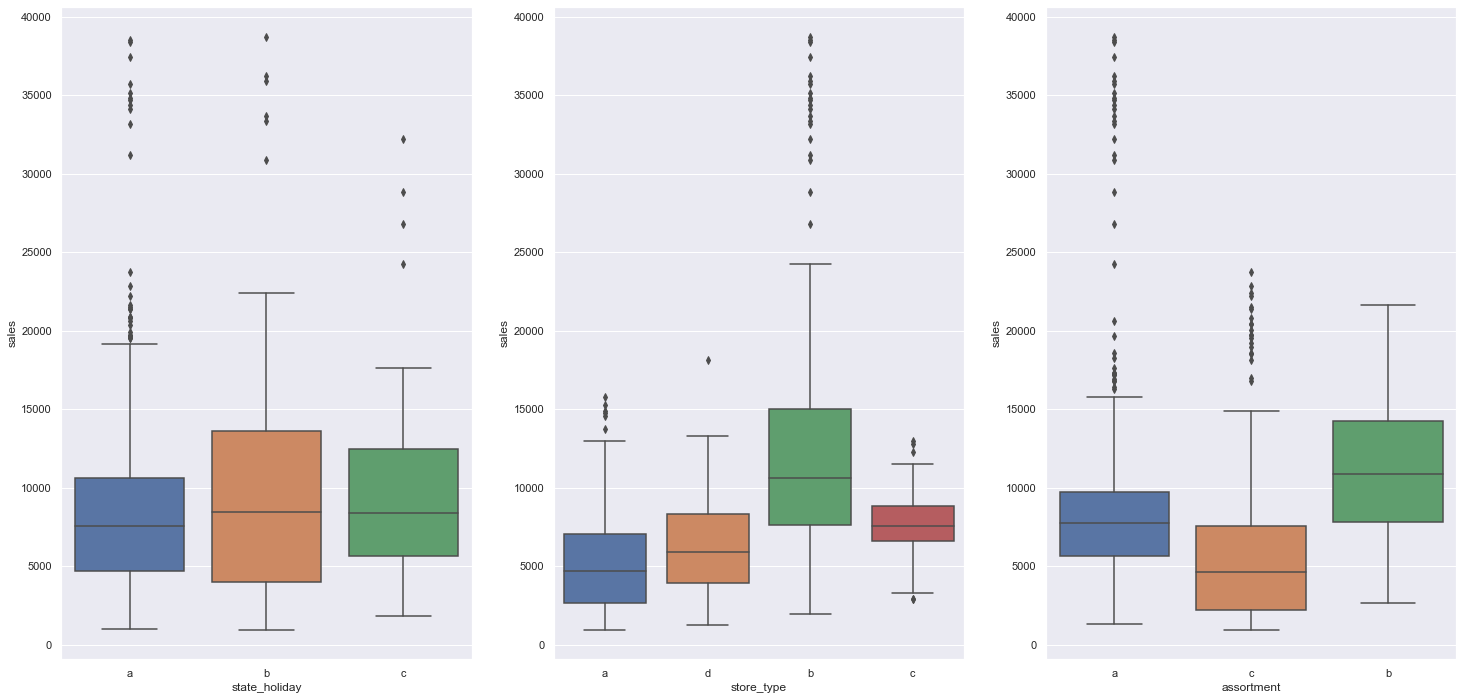

In [36]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)] #Apenas vendas maiores que 0
#Filtro dos dias que nao havia vendas
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux ) #

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

In [39]:
## C tem uma concentração em torno da media em store-tyoe
# A & B Mediana mais similar
# Assortment : B mais distribuido. No A mais outliers